In this notebook we'll show how to use STARsolo to process ddSeq scRNA-seq data, and compare the results to those generated by ddSeeker--another tool for processing ddSeq data. We'll be using a dataset provided by Illumina which contains a mixture of human and mouse cells and is used in the [ddSeeker paper](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-018-5249-x).

The dataset used in this notebook must be obtained through Illumina BaseSpace [here](https://basespace.illumina.com). Through BaseSpace, download the fastqs for Sample A of the "NextSeq SureCell WTA 3 Mixed Species HEK 3T3 1400 cell" dataset.

# Running STARsolo

Since the dataset is mixed species, we also need a mixed species reference for STAR.

In [ ]:
!wget https://link.to.reference/

You can use STARsolo to process ddSeq data by simply passing the following parameters which tell STARsolo how to parse the barcodes: 

In [ ]:
--soloCBposition 2_-6_2_-1 3_1_3_6 3_22_3_27 
--soloUMIposition 3_31_3_39 
--soloAdapterSequence TAGCCATCGCATTGC 
--soloCBmatchWLtype 1MM

Here is an example of the full command to STAR. In this, you'll need to provide the correct paths to the appropriate files on your system (STAR executable, reference genome, whitelist, and fastqs):

In [ ]:
STAR --readFilesCommand zcat --soloType CB_UMI_Complex --soloCBwhitelist ddSeq.whitelist 
--soloFeatures Gene --runThreadN 1 --outSAMtype None --genomeDir /path/to/ref_genome 
--readFilesIn /path/to/R2.fastq /path/to/R1.fastq --soloCBposition 2_-6_2_-1 3_1_3_6 3_22_3_27 
--soloUMIposition 3_31_3_39 --soloAdapterSequence TAGCCATCGCATTGC --soloCBmatchWLtype 1MM
--genomeLoad LoadAndKeep --readMapNumber -1

We won't cover the full details of running ddSeeker here, this can be found at their [github](https://github.com/cgplab/ddSeeker). The counts used in the comparison was produced with the dropseq-tools script they provide. If you wish to replicate this, note that you must use an older version of dropseq-tools compatible with their script (1.13 was used here).

# Preprocessing for Analysis

We'll be using Pandas and ScanPy to compare the results from STARsolo and ddSeeker both quantitatively and qualitatively. Load the appropriate libraries:

In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
from scipy.stats import pearsonr
import plotly.express as px
from tqdm import tqdm
import pandas as pd
import plotly.figure_factory as ff

First we'll load and process the counts with ScanPy for both methods. For ddSeeker the top 350 cells were output as in the paper.

First read the ddSeeker counts--the ddSeeker pipeline filters out some genes by this stage.

In [2]:
ddseq_counts = sc.read_text('/path/to/ddSeeker/counts/star_gene_exon_tagged.dge.txt',
                           first_column_names=True)
ddseq_counts = ddseq_counts.T

In [3]:
ddseq_counts

AnnData object with n_obs × n_vars = 350 × 30882

Read STARsolo counts. We can see that the default filtering from STARsolo includes a few more cells.

In [4]:
solo_counts = sc.read_10x_mtx('/scratch/blibaum/SingleCellData/ddSeq/star_runs/Solo.out/Gene/filtered/')

In [5]:
solo_counts

AnnData object with n_obs × n_vars = 367 × 64591
    var: 'gene_ids'

Filter/align genes and barcodes to be the same for both methods. Note that the barcodes output from STARsolo need a little processing to align with those output from ddSeeker as the three separate barcodes are output separated by an underscore.

In [6]:
# Align the gene sets
solo_counts_aligned = solo_counts[:, ddseq_counts.var_names]

# Remove the underscores from STARsolo barcodes so they can be matched with those from ddSeeker
solo_counts_aligned.obs_names = solo_counts_aligned.obs_names.str.replace('_', '')

# Find the common barcodes present in the STARsolo and ddSeeker output
common_cells = ddseq_counts.obs_names.intersection(solo_counts_aligned.obs_names)

# Filter the STARsolo and ddSeeker data to the common barcodes
solo_counts_aligned = solo_counts_aligned[common_cells]
ddseq_counts = ddseq_counts[common_cells]

Quick check to see that barcodes/genes are aligned. We can see there's a difference of two cells between the ddSeeker and STARsolo output.

In [7]:
ddseq_counts.obs_names

Index(['GAGGCCGCTTGTCTAGGT', 'CTTGAACGGTCCTACCGA', 'CAGACTGGACGAACCTTC',
       'CCGTAACTTGAAAATTGG', 'GCGCGGGGACGAGTACAG', 'ATTAGTCTGTGGGCGAAT',
       'GGCCATTTAAGACAGGAG', 'GGGATCGTCCTAGTCGGC', 'ACAAGGAGTCTGAGATGT',
       'GATCAACGAGCATGTGTA',
       ...
       'TTGGATTCGCCTGGGATC', 'TGTGTATGTTCGAGGTTA', 'CACTGTTTCTTGGGACGA',
       'GACTCGTTCTTGAGGTTA', 'TCAGTGATAGCGAGTAAA', 'TCAGTGTGCGGTGATCAA',
       'GGTAGGTCTAGCGATCAA', 'GGTGCTTCTAGCAACGTG', 'GGTGCTTGTTCGGCCGTT',
       'TTCGCACCGATGGTCCTA'],
      dtype='object', length=348)

In [8]:
solo_counts_aligned.obs_names

Index(['GAGGCCGCTTGTCTAGGT', 'CTTGAACGGTCCTACCGA', 'CAGACTGGACGAACCTTC',
       'CCGTAACTTGAAAATTGG', 'GCGCGGGGACGAGTACAG', 'ATTAGTCTGTGGGCGAAT',
       'GGCCATTTAAGACAGGAG', 'GGGATCGTCCTAGTCGGC', 'ACAAGGAGTCTGAGATGT',
       'GATCAACGAGCATGTGTA',
       ...
       'TTGGATTCGCCTGGGATC', 'TGTGTATGTTCGAGGTTA', 'CACTGTTTCTTGGGACGA',
       'GACTCGTTCTTGAGGTTA', 'TCAGTGATAGCGAGTAAA', 'TCAGTGTGCGGTGATCAA',
       'GGTAGGTCTAGCGATCAA', 'GGTGCTTCTAGCAACGTG', 'GGTGCTTGTTCGGCCGTT',
       'TTCGCACCGATGGTCCTA'],
      dtype='object', length=348)

In [9]:
ddseq_counts.var_names

Index(['hg19_A1BG', 'hg19_A1BG-AS1', 'hg19_A2M', 'hg19_A2M-AS1', 'hg19_A4GALT',
       'hg19_A4GNT', 'hg19_AAAS', 'hg19_AACS', 'hg19_AADAT', 'hg19_AAED1',
       ...
       'mm10_Zyx', 'mm10_Zzef1', 'mm10_Zzz3', 'mm10_mt-Co1', 'mm10_mt-Cytb',
       'mm10_mt-Nd1', 'mm10_mt-Nd2', 'mm10_mt-Nd4', 'mm10_mt-Nd5',
       'mm10_mt-Nd6'],
      dtype='object', length=30882)

In [10]:
solo_counts_aligned.var_names

Index(['hg19_A1BG', 'hg19_A1BG-AS1', 'hg19_A2M', 'hg19_A2M-AS1', 'hg19_A4GALT',
       'hg19_A4GNT', 'hg19_AAAS', 'hg19_AACS', 'hg19_AADAT', 'hg19_AAED1',
       ...
       'mm10_Zyx', 'mm10_Zzef1', 'mm10_Zzz3', 'mm10_mt-Co1', 'mm10_mt-Cytb',
       'mm10_mt-Nd1', 'mm10_mt-Nd2', 'mm10_mt-Nd4', 'mm10_mt-Nd5',
       'mm10_mt-Nd6'],
      dtype='object', length=30882)

Convert the data from the AnnData objects to dataframes and stack to make comparison efficient.

In [11]:
counts_ss_df = solo_counts_aligned.to_df()
counts_dd_df = ddseq_counts.to_df()
counts_dd_df = counts_dd_df.stack()
counts_ss_df = counts_ss_df.stack()

## Analysis

First, we'll look at a qualitative analysis of how the counts correlate between the two methods on a count-by-count basis. Then, we'll look at how the results compare qualitatively by comparing the clustering and differential expression from ScanPy. We expect there to be some small differences in the results due to differences in the algorithms that produce the gene counts, but they should be qualitatively similar.

In [12]:
all_df = pd.concat([counts_ss_df, counts_dd_df], axis=1)
all_df.columns = ["STARsolo", "ddSeeker"]

To start off we'll look at the raw correlations between the output.

Pearson correlation of the raw counts between STARsolo and ddSeeker:

In [13]:
all_df.corr()

,STARsolo,ddSeeker
STARsolo,1.000000,0.920859
ddSeeker,0.920859,1.000000


Spearman correlation of the raw counts:

In [14]:
all_df.corr(method='spearman')

,STARsolo,ddSeeker
STARsolo,1.000000,0.971728
ddSeeker,0.971728,1.000000


Pearson correlation of the log2 transformed counts, which are more relevant for downstream analysis:

In [15]:
all_df.transform(lambda x: np.log2(x+1)).corr()

,STARsolo,ddSeeker
STARsolo,1.000000,0.975285
ddSeeker,0.975285,1.000000


As a more detailed analysis, we'll look at the distribution of the magnitudes of differences for individual counts. To do this we'll plot the percentage of counts that have a certain fold difference between the methods. We'll also make a cutoff at 10 counts to be included in the comparison to make the results more meaningful.

In [16]:
count_threshold = 10

df1 = counts_dd_df.astype(np.float32)
df2 = counts_ss_df.astype(np.float32)

# Mask out low counts
mask_vals = (df1 < count_threshold) & (df2 < count_threshold)
df1.mask(mask_vals, inplace=True)
df2.mask(mask_vals, inplace=True)
df1.replace(0.0, np.nan, inplace=True)
df2.replace(0.0, np.nan, inplace=True)

# Compute the log2 fold differences
ratios = np.abs(np.log2(df1 / df2)).dropna()

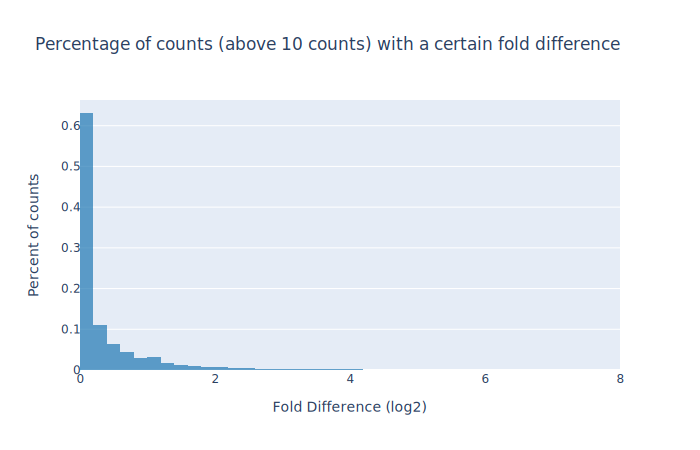

In [18]:
# Make the plot with a bin size of 0.2
fig = ff.create_distplot([ratios.to_numpy()], ['Ratio counts'], show_rug=False,
                         show_curve=False, bin_size=0.2, histnorm='probability')
fig.update_xaxes(title_text='Fold Difference (log2)')
fig.update_yaxes(title_text='Percent of counts')
fig.update_layout(title_text='Percentage of counts (above 10 counts) with a certain fold difference')
fig.show('svg')

Secondly, we'll see how the counts correlate as a function of the size of the counts by computing the correlation only considering counts above a certain threshold.

In [19]:
threshold_max = 100

r_values = []
for threshold_val in tqdm(range(0, threshold_max, 2)):
    # Mask out values less than threshold_val from being considered in the correlation
    dataset1_filtered = counts_dd_df.mask(counts_dd_df < threshold_val)
    dataset2_filtered = counts_ss_df.mask(counts_ss_df < threshold_val)

    dataset1_filtered += 1
    dataset2_filtered += 1
    dataset1_filtered = dataset1_filtered.apply(np.log2)
    dataset2_filtered = dataset2_filtered.apply(np.log2)

    corr = dataset1_filtered.corr(dataset2_filtered)
    r_values.append(corr)

100%|██████████| 50/50 [04:01<00:00,  4.82s/it]


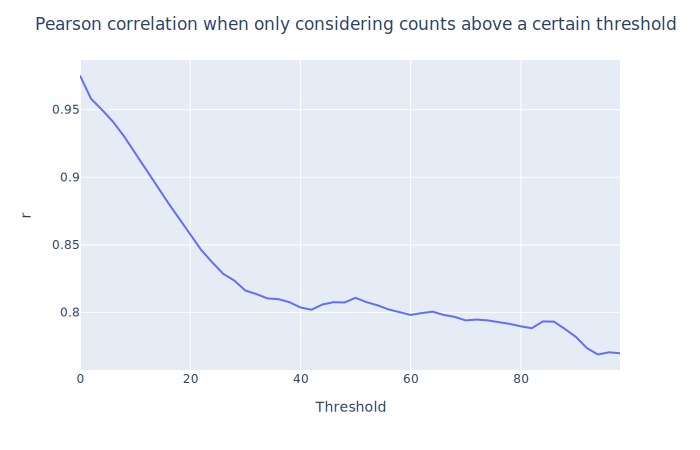

In [20]:
r_df = pd.DataFrame(zip(r_values, range(0, threshold_max, 2)), columns=["r", "Threshold"])
px.line(r_df, x='Threshold', y='r').update_layout(title_text='Pearson correlation when only considering counts above a certain threshold').show('svg')

Now we'll look at how the downstream results compare by running both counts through a standard ScanPy pipeline and comparing the clustering and DE.

In [ ]:
solo_adata = solo_counts_aligned
dds_adata = ddseq_counts

Do filtering and compare some QC metrics:

In [23]:
sc.pp.filter_cells(solo_adata, min_genes=200)
sc.pp.filter_genes(solo_adata, min_cells=3)
sc.pp.filter_cells(dds_adata, min_genes=200)
sc.pp.filter_genes(dds_adata, min_cells=3)

sc.pp.calculate_qc_metrics(solo_adata, percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(dds_adata, percent_top=None, log1p=False, inplace=True)

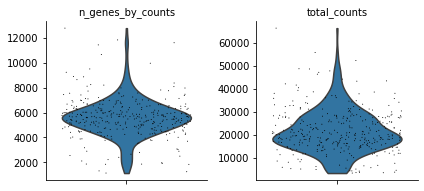

In [24]:
# STARsolo
sc.pl.violin(solo_adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True)

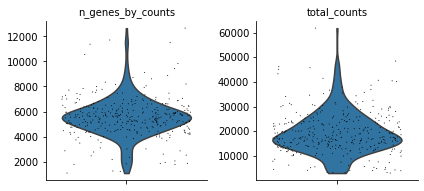

In [25]:
# ddSeeker
sc.pl.violin(dds_adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True)

Run a standard preprocessing pipeline and compute UMAP/clustering:

In [26]:
def apply_preprocessing(adata):
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    adata.raw = adata
    adata = adata[:, adata.var.highly_variable]
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
    sc.tl.umap(adata)
    sc.tl.leiden(adata)
    sc.tl.rank_genes_groups(adata, 'leiden')
    return adata

In [27]:
solo_adata = apply_preprocessing(solo_adata)
dds_adata = apply_preprocessing(dds_adata)

/home/blibaum/miniconda3/envs/sc36/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:848: UserWarning:

Revieved a view of an AnnData. Making a copy.

/home/blibaum/miniconda3/envs/sc36/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:848: UserWarning:

Revieved a view of an AnnData. Making a copy.



Compare UMAP/clustering:

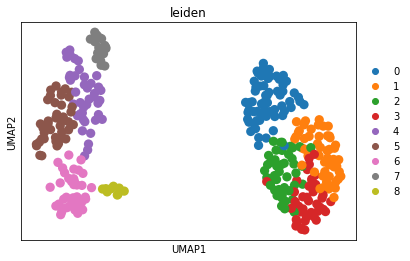

In [29]:
# STARsolo
sc.pl.umap(solo_adata, color='leiden')

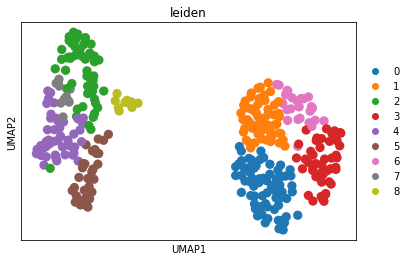

In [30]:
# ddSeeker
sc.pl.umap(dds_adata, color='leiden')

Compare a DE heatmap between the clusters. We can see that both methods look similar and deconvolve the mouse and human cells.

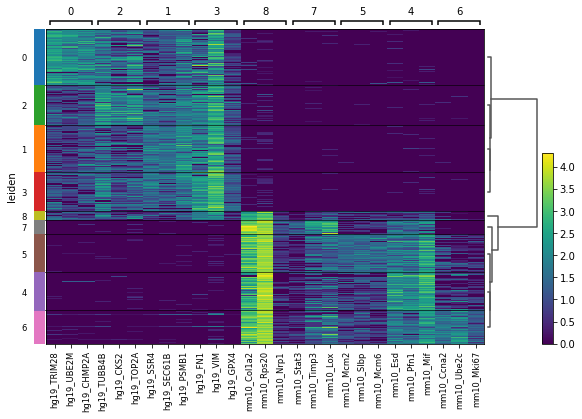

In [41]:
# STARsolo
sc.pl.rank_genes_groups_heatmap(solo_adata, n_genes=3)

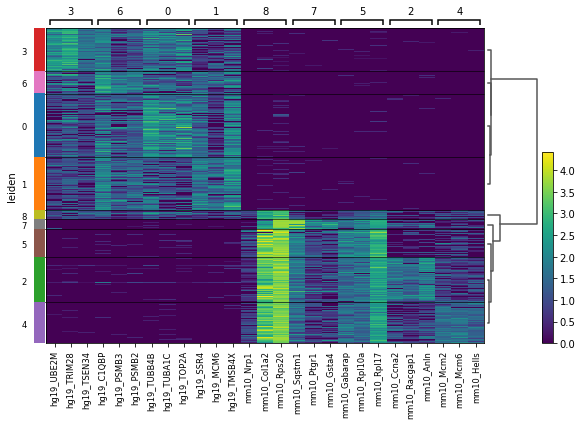

In [39]:
# ddSeeker
sc.pl.rank_genes_groups_heatmap(dds_adata, n_genes=3)